# Homework 5 - The Marvel Universe!

In [33]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#!pip install install --quiet

In [34]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict

## 1. Data

### Preprocessing

In [35]:
nodes = pd.read_csv('nodes.csv')

In [36]:
edges = pd.read_csv('edges.csv')

In [37]:
hero = pd.read_csv('hero-network.csv')

Take a look

In [ ]:
nodes.info()

In [ ]:
edges.info()

In [ ]:
hero.info()

We will not have to deal with NA values, now let's see in what format are the names/words written

In [ ]:
nodes.head(10)

In [ ]:
nodes.nunique()

In [ ]:
edges.head(10)

In [ ]:
edges.nunique()

In [ ]:
hero.head(10)

In [ ]:
hero.nunique()

##### Problems:
 - Some heroes' names in 'hero-network.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'
 - Some heroes' names in 'hero-network.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'
 - The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'
 - Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.

First of all, we remove the extra characters from the neroes' names.

In [38]:
hero["hero1"] = hero["hero1"].str.rstrip('/ ')
hero["hero2"] = hero["hero2"].str.rstrip('/ ')

In [ ]:
hero.head(10)

In [ ]:
hero.nunique()

We have less unique values after the rstrip, so there were actually some names that were the same but with extra characters.

Now let's change Spiderman's name in the hero dataframe to the complete 'SPIDER-MAN/PETER PARKER'.

In [39]:
hero[hero["hero1"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'
hero[hero["hero2"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'

In [40]:
print(hero[hero["hero1"]=='SPIDER-MAN/PETER PAR'].shape)
print(hero[hero["hero2"]=='SPIDER-MAN/PETER PAR'].shape)

(0, 2)
(0, 2)


Done! No more short name for Spiderman.

### Graphs setup

**First graph**: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

First of all, we need to define a metric to calculate the weights so that the heroes with more collaborations has a lower 'cost'. In order to match the number of collaborations with an appropriate weight, we can use the inverse of the normalized number of collaborations for each hero. Just applying $\frac{(\max - X)}{(\max - \min)}$ to each value, we will obtain a 'cost' scaled between 0 and 1, meaning that if a collaboration has a weight close to 0 it is much more important than a collaboration with a weight close to 1.

We create a column with the number of collaboration for each pair of heroes.

In [41]:
hero['number of coll'] = hero.groupby(['hero1', 'hero2'])['hero1'].transform('count')

In [ ]:
hero

We will use it only to compute the normalization, then we will delete it.

In [42]:
MAX = hero['number of coll'].max()

In [43]:
MIN = hero['number of coll'].min()

In [ ]:
print(MAX)
print(MIN)

In [44]:
hero['weight'] = (MAX - hero['number of coll'])/(MAX - MIN)

In [ ]:
hero.head(15)

In [45]:
hero = hero.drop('number of coll', axis=1)

In [ ]:
hero

Now we will use the NetworkX package and functions to create our graph.

In [46]:
graph1 = nx.from_pandas_edgelist(hero, 'hero1', 'hero2', edge_attr='weight')

In [ ]:
nx.draw(graph1)

**Second graph**: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

In [47]:
graph2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')

In [48]:
graph2.add_nodes_from(nodes['node'], type=nodes['type'])

In [76]:
nx.info(graph2)

'Graph with 19091 nodes and 96104 edges'

### 2.1. Functionality 1 - Extract the graph's features

As the number of nodes and edges grows, it might be useful to work on a subset of the data to reduce computation time and improve the network visualization.
<br>
<br>
For this reason we will consider the **Top N heroes**: which are the **N** heroes who have appeared in the most number of comics

In [17]:
def top_N(df, N):return df.groupby('hero').count().sort_values(['comic'], ascending = False).iloc[:N]

In [23]:
top_N(edges, 10)['comic']

hero
SPIDER-MAN/PETER PARKER    1577
CAPTAIN AMERICA            1334
IRON MAN/TONY STARK        1150
THING/BENJAMIN J. GR        963
THOR/DR. DONALD BLAK        956
HUMAN TORCH/JOHNNY S        886
MR. FANTASTIC/REED R        854
HULK/DR. ROBERT BRUC        835
WOLVERINE/LOGAN             819
INVISIBLE WOMAN/SUE         762
Name: comic, dtype: int64

In [ ]:
edges.groupby('comic').count().sort_values(['hero'], ascending= False)

The output for this functionality must contain:
- the number of nodes in the network (if type 2, report for both node types)
- the number of collaborations of each superhero with the others (*! Only if type 1*)
- the number of heroes that have appeared in each comic (*! Only if type 2*)
- the network's density
- the network's degree distribution
- the average degree of the network
- the network's hubs
- whether the network is spares or dense

let's define some functions

In [ ]:
edges.groupby('comic').count()

#### Density of a graph

Both in the case of graph type 1 and 2, we are dealing with *undirected* graph, thus the density can be computed as: $$d = \frac{2\cdot m}{n \cdot (n-1)}$$
where **n** is the number of nodes and **m** is the number of edges in the graph.

In [ ]:
def graph_density(G):
    return 2*len(list(G.edges())) / (len(list(G.nodes()))*(len(list(G.nodes())-1)))

#### Degree Distribution

The degree distribution $P(k)$ of a graph is the fraction of nodes in the network with degree $k$.
<br>

Thus if the there are $n$ nodes in total in a network, and $n_k$ of them have degree $k$, we have: $$P(k)=\frac{n_k}{n}$$



#### Network's hubs

Hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution


#### Sparsity vs. Density

We can say that, if the graph's density is close to 1, the graph **dense**, meanwhile it is **sparse** if the density is close to 0. 


In [70]:
class func1():

    def __init__(self, graph, graph_type, n:int, dataframe=edges):
        self.graph = graph
        self.graph_type = graph_type
        self.n = n
        self.dataframe = dataframe

        top_heroes = edges.groupby('hero', as_index=False).count().sort_values(by='comic',ascending=False).rename(columns={'comic':'Count'})
        toppe = edges[edges['hero'].isin(top_heroes.head(self.n)['hero'])]

        self.n_nodes = pd.unique(toppe['hero']).tolist() + pd.unique(toppe['comic']).tolist()
        self.sub_graph = nx.induced_subgraph(graph, self.n_nodes)
        self.sub_graph.graph_type = graph_type


    def count_nodes(self):

        if self.graph_type == 1:

            if self.n == len(self.graph.nodes()):
                g1 = self.graph
                nodes = set()

                for edge in g1.edges():
                    nodes.add(edge[0])
                    nodes.add(edge[1])

                return len(nodes)
            else:
                g1 = self.sub_graph
                nodes = set()

                for edge in g1.edges():
                    nodes.add(edge[0])
                    nodes.add(edge[1])

                return len(nodes)

        elif self.graph_type == 2:

            if self.n == len(self.graph.nodes()):
                g2 = self.graph
                heroes = set()
                comics = set()

                for edge in g2.edges():

                    heroes.add(edge[0])
                    comics.add(edge[1])
                return len(heroes), len(comics)
            else:
                g2 = self.sub_graph
                heroes = set()
                comics = set()

                for edge in g2.edges():

                    heroes.add(edge[0])
                    comics.add(edge[1])
                return len(heroes), len(comics)



    def count_collaborations(self):

        if self.graph_type == 1:

            if self.n == len(self.graph.nodes()):

                degrees = {}

                for edge in self.graph.edges():
                    if edge[0] not in degrees:
                        degrees[edge[0]] = 0
                    if edge[1] not in degrees:
                        degrees[edge[1]] = 0
                    degrees[edge[0]] += 1
                    degrees[edge[1]] += 1
                
                return degrees
            else:

                degrees = {}

                for edge in self.sub_graph.edges():
                    if edge[0] not in degrees:
                        degrees[edge[0]] = 0
                    if edge[1] not in degrees:
                        degrees[edge[1]] = 0
                    degrees[edge[0]] += 1
                    degrees[edge[1]] += 1
                
                return degrees


        else:
            print('Functionality doesn`t exist for this type of graph')

    def comic_appearence(self):

        if self.graph_type == 2:

            comic_set = {i for i in self.dataframe['comic']}
            comic_count = defaultdict(int)

            for edge in self.graph.edges():

                if edge[0] in comic_set:
                    comic_count[edge[0]] += 1
                if edge[1] in comic_set:
                    comic_count[edge[1]] += 1
            
            return comic_count
        else:
            print('Functionality doesn`t exist for this type of graph')

    def graph_density(self):
        if self.n == len(self.graph.nodes()):
            return 2*len(list(self.graph.edges())) / (len(list(self.graph.nodes()))*(len(list(self.graph.nodes()))-1))
        else:
            return 2*len(list(self.sub_graph.edges())) / (len(list(self.sub_graph.nodes()))*(len(list(self.sub_graph.nodes()))-1))

    def degree_distro(self):

        degree = {}
        if self.n == len(self.graph.nodes()):
            for edge in self.graph.edges():
                if edge[0] not in degree:
                    degree[edge[0]] = 0
                else:
                    degree[edge[0]] += 1
                
                if edge[1] not in degree:
                    degree[edge[1]] = 0
                else:
                    degree[edge[1]] += 1

            distros = {}

            for i in degree:
                distros.update({i: degree[i]/len(degree)})

            return distros
        else:
            for edge in self.sub_graph.edges():
                if edge[0] not in degree:
                    degree[edge[0]] = 0
                else:
                    degree[edge[0]] += 1
                
                if edge[1] not in degree:
                    degree[edge[1]] = 0
                else:
                    degree[edge[1]] += 1

            distros = {}

            for i in degree:
                distros.update({i: degree[i]/len(degree)})

            return distros


    def average_degree(self):
        
        if self.n == len(self.graph.nodes()):
            degree = {}

            for edge in self.graph.edges():
                if edge[0] not in degree:
                    degree[edge[0]] = 0
                else:
                    degree[edge[0]] += 1
                
                if edge[1] not in degree:
                    degree[edge[1]] = 0
                else:
                    degree[edge[1]] += 1

            degree_list = list(degree.values())

            return sum(degree_list)/len(degree)
        else:
            degree = {}

            for edge in self.sub_graph.edges():
                if edge[0] not in degree:
                    degree[edge[0]] = 0
                else:
                    degree[edge[0]] += 1
                
                if edge[1] not in degree:
                    degree[edge[1]] = 0
                else:
                    degree[edge[1]] += 1

            degree_list = list(degree.values())

            return sum(degree_list)/len(degree)


    def find_hubs(self):

        distro_dict = self.degree_distro()

        distros = list(distro_dict.values())

        percentiles = np.percentile(distros, 95)
        
        hubs = [i for i in distro_dict.values() if i > percentiles ]

        return hubs

    def check_sparsity(self):
            if self.graph_density() < 0.5:
                return 0
            else:
                return 1



    def visualization(self):

        #number of nodes of the graph
        if self.graph_type == 1:
            n_nodes_dict = dict()

            n_nodes = self.count_nodes()
            n_nodes_dict.update({'Number of Nodes': n_nodes})

    

            print(tabulate(n_nodes_dict.items(),tablefmt="grid"))
        elif self.graph_type == 2:
            data = dict()

            n_heroes, n_comics = self.count_nodes()

            data.update({'Number of Heroes': n_heroes})
            data.update({'Number of Comics': n_comics})

            print("(Graph Type%d) Number of Nodes [Heroes vs. Comics]" %self.graph_type)
            print(tabulate(data.items(), tablefmt="grid"))
        
        else:
            print("Graph Type not defined")
        
        #(Only if type 1) Number of collaborations
        if self.graph_type == 1:
            print("Number of nodes for graph type %d:" %self.graph_type)
            print(tabulate(self.count_collaborations().items(),headers=["Heroe", "Number of Collaborations"],tablefmt="grid"))

        #(Only if type 2) Count comic appeareance
        if self.graph_type == 2:

            colab_list = [(k,v) for k,v in self.comic_appearence().items()]

            print("(Graph Type%d) Number of collaborations: " %self.graph_type)
            print(tabulate(colab_list,tablefmt="grid"))

        #Graph density
        density = dict()
        dens = self.graph_density()

        density.update({'Density': dens})

        print(tabulate(density.items(), tablefmt="grid"))

        #Graph degree distribution

        distro = self.degree_distro()
        distro_list = sorted(list(distro.values()))

        sns.histplot(distro_list)
        plt.title('Degree Distribution')
        #plt.xlim(0,0.01)
        #plt.ylim(0,1500)
        plt.show()

        #Average degree
        avg_degree_dict = dict()

        avg_deg = self.average_degree()

        avg_degree_dict.update({'Average Degree': avg_deg})

        print(tabulate(avg_degree_dict.items(), tablefmt="grid"))

        #Sparsity vs. Dense
        if self.check_sparsity() == 1:
            print("Graph %d is dense" %self.graph_type)
        else:
            print('Graph %d is sparse' %self.graph_type)        

In [71]:
test = func1(graph1, graph_type=1,n=10)

In [64]:
test.count_nodes()

10

In [65]:
test.count_collaborations()

{'IRON MAN/TONY STARK': 8,
 'HULK/DR. ROBERT BRUC': 8,
 'INVISIBLE WOMAN/SUE': 8,
 'THING/BENJAMIN J. GR': 8,
 'CAPTAIN AMERICA': 10,
 'WOLVERINE/LOGAN': 8,
 'MR. FANTASTIC/REED R': 8,
 'THOR/DR. DONALD BLAK': 8,
 'HUMAN TORCH/JOHNNY S': 8,
 'SPIDER-MAN/PETER PARKER': 2}

In [66]:
test.graph_density()

0.8444444444444444

+-----------------+----+
| Number of Nodes | 10 |
+-----------------+----+
Number of nodes for graph type 1:
+-------------------------+----------------------------+
| Heroe                   |   Number of Collaborations |
+=========================+============================+
| IRON MAN/TONY STARK     |                          8 |
+-------------------------+----------------------------+
| HULK/DR. ROBERT BRUC    |                          8 |
+-------------------------+----------------------------+
| INVISIBLE WOMAN/SUE     |                          8 |
+-------------------------+----------------------------+
| THING/BENJAMIN J. GR    |                          8 |
+-------------------------+----------------------------+
| CAPTAIN AMERICA         |                         10 |
+-------------------------+----------------------------+
| WOLVERINE/LOGAN         |                          8 |
+-------------------------+----------------------------+
| MR. FANTASTIC/REED R    |         

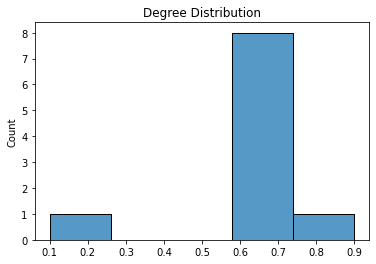

+----------------+-----+
| Average Degree | 6.6 |
+----------------+-----+
Graph 1 is dense


In [72]:
test.visualization()

In [68]:
test_bis = func1(graph2, graph_type=2, n=10)

In [ ]:
test_bis.visualization()

#### 2.4 Functionality 4 - Disconnecting Graph

Input:
- The graph data
- heroA: a superhero to which will relate sub-graph $G_a$
- heroB: a superhero to which will relate sub-graph $G_b$
- N: denoting the top N heroes that their data should be considered

Output:
- The minimun number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: $G_a$ and $G_b$ 

In [ ]:
class func4():
    
    def __init__(self, graph, heroA, heroB, N:int):

        self.graph = graph
        self.heroA = heroA
        self.heroB = heroB
        self.N = N

In [78]:
def bfs(graph, source):
    visited = []
    queue = []

    queue.append(source)

    while queue:
        m = queue.pop(0)

        for neighbour in graph[m]:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)
